# 1. Kiểm tra GPU và CUDA

In [1]:
import torch
import subprocess

print("===== GPU =====")
print(subprocess.getoutput("nvidia-smi"))

print("\n===== CUDA Torch =====")
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Torch CUDA version:", torch.version.cuda)


===== GPU =====
/bin/sh: 1: nvidia-smi: not found

===== CUDA Torch =====
Torch version: 2.8.0+cu126
CUDA available: False
Torch CUDA version: 12.6


# 2. Gỡ bỏ các package cũ

Gỡ bỏ các thư viện liên quan đến NLP/LLM đã cài sẵn để tránh xung đột phiên bản:

In [2]:
!pip uninstall -q -y transformers accelerate peft trl bitsandbytes unsloth unsloth-zoo protobuf

# 3. Cài đặt các thư viện cần thiết

Cài đặt các thư viện và framework cần thiết cho project dịch thuật y khoa:
- `protobuf==3.20.3`: Thư viện serialization
- `transformers==4.57.3`: Thư viện chính của HuggingFace
- `accelerate==1.12.0`: Hỗ trợ distributed training
- `peft==0.13.2`: Parameter-Efficient Fine-Tuning (LoRA)
- `trl==0.24.0`: Transformer Reinforcement Learning
- `datasets`: Thư viện xử lý dataset của HF
- `safetensors`, `sentencepiece`: Định dạng file
- `evaluate`, `sacrebleu`: Đánh giá mô hình dịch
- `sentence-transformers`: Embeddings

In [3]:
!pip install -q --no-cache-dir \
    "protobuf==3.20.3" \
    "transformers==4.57.3" \
    "accelerate==1.12.0" \
    "peft==0.13.2" \
    "trl==0.24.0" \
    "datasets>=2.13.0" \
    "safetensors" \
    "sentencepiece" \
    "huggingface-hub" \
    "evaluate" \
    "sacrebleu" \
    "sentence-transformers"
print("Done")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 234.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 161.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 321.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 333.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 262.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 265.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is 

# 4. Tải mô hình Qwen2.5-3B-Instruct

Tải mô hình base và tokenizer từ HuggingFace:
- Mô hình: `Qwen/Qwen2.5-3B-Instruct` (3 tỷ tham số)
- Sử dụng `device_map="auto"` để tự động phân bổ GPU/CPU
- `dtype="auto"` để tự động chọn kiểu dữ liệu
- `quantization_config=None`: Không sử dụng quantization của bitsandbytes
- `trust_remote_code=True`: Cho phép code tùy chỉnh

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-3B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    dtype="auto",              # thay cho torch_dtype
    trust_remote_code=True,
    quantization_config=None,  # BẮT BUỘC để tắt BnB
)

print("Done")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

2025-12-22 23:17:43.592356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766445463.833218      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766445463.900512      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766445464.479085      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766445464.479132      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766445464.479140      55 computation_placer.cc:177] computation placer alr

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Done


# 5. Tải dữ liệu training và test

Tải dataset dịch thuật y khoa từ thư mục Kaggle

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# --- Configuration ---
DATA_DIR = "/kaggle/input/medical-data"
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def read_file(path):
    with open(path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f]

# --- Load Raw Data ---
print("Loading raw text files...")
train_en = read_file(os.path.join(DATA_DIR, "train.en.txt"))
train_vi = read_file(os.path.join(DATA_DIR, "train.vi.txt"))
test_en = read_file(os.path.join(DATA_DIR, "public_test.en.txt"))
test_vi = read_file(os.path.join(DATA_DIR, "public_test.vi.txt"))

assert len(train_en) == len(train_vi)
print(f"Successfully loaded {len(train_en)} training pairs and {len(test_en)} test pairs.")

Loading raw text files...
Successfully loaded 500000 training pairs and 3000 test pairs.


# 6. Phân tích thống kê Dataset gốc

Thực hiện phân tích và trực quan hóa dữ liệu gốc:
- Hàm `analyze_stats_pro()`: Tính độ dài câu và tìm các viết tắt y khoa
- Tạo bảng thống kê tổng hợp (tổng câu, độ dài TB, độ dài max, số lượng viết tắt)
- Vẽ biểu đồ phân phối độ dài câu (English vs Vietnamese)
- Vẽ biểu đồ 15 viết tắt y khoa phổ biến nhất
- Hiển thị câu dài nhất để phát hiện outliers

Analyzing Original Dataset Statistics...

STATISTICAL SUMMARY OF ORIGINAL DATASET
               Metrics English Corpus Vietnamese Corpus
       Total Sentences         500000            500000
Average Length (words)          21.31             30.22
    Max Length (words)            477               519
  Unique Abbreviations          15099             13167


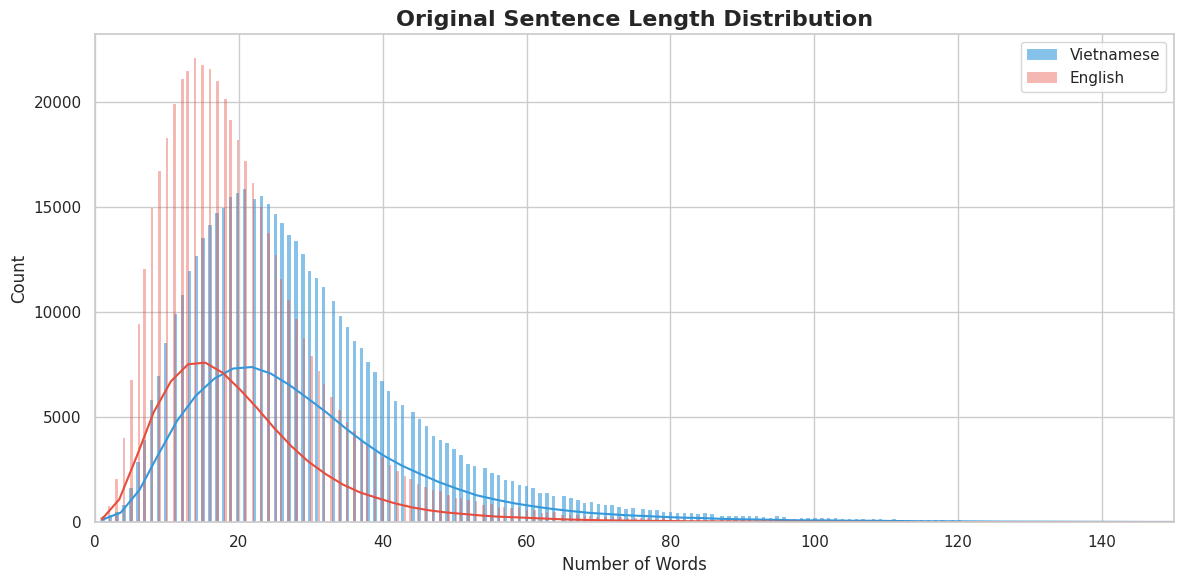

Generating Original Abbreviation Charts...


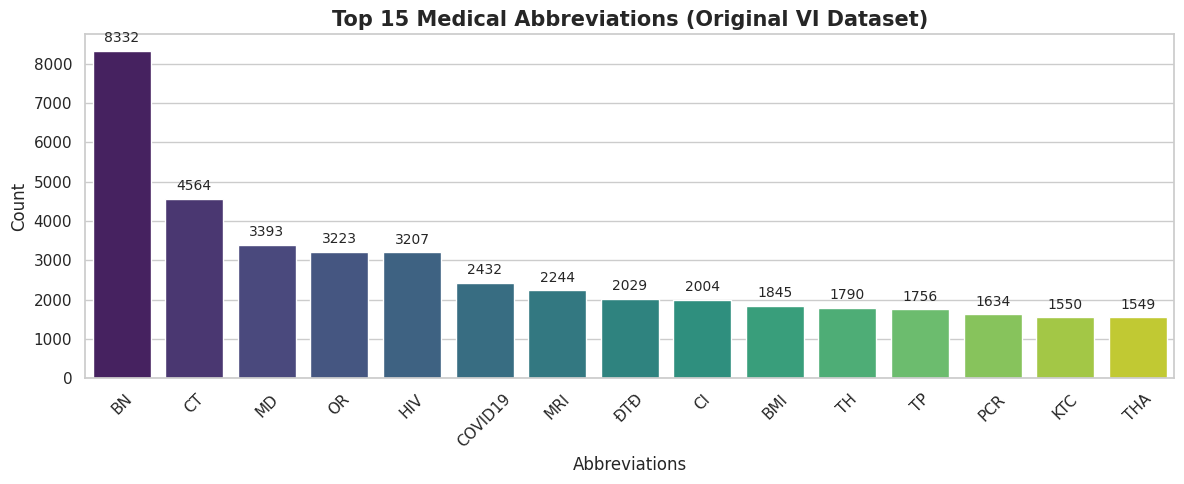

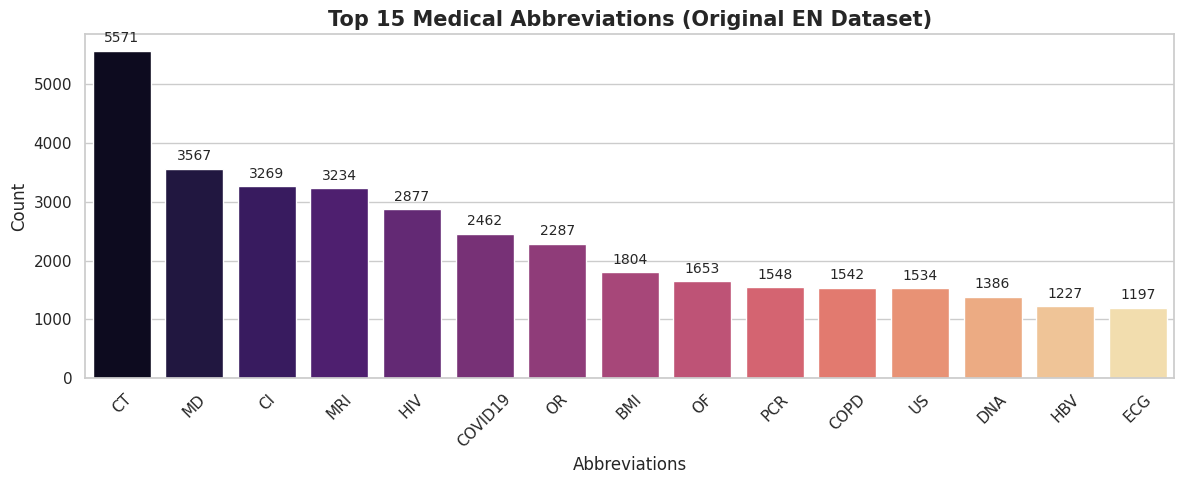


------------------------------------------------------------
DEBUG: Longest VI Sample (519 words):
Chỉ định mở màng nhẫn giáp qua da Ngưng thở, suy hô hấp nặng hoặc sắp ngừng hô hấp cần đặt nội khí quản và một trong hai Thất bại trong nỗ lực đặt nội khí quản miệng hoặc khí quản mũi khi không có khả năng cung cấp oxy hoặc thông khí bằng các phương pháp thay thế (ví dụ: bóng bóp-van-mặt nạ, bộ đườn...

DEBUG: Longest EN Sample (477 words):
Typically the lesions that can be detected with MRI are those that contain blood products 23. hemorrhagic powder burn lesions appear bright on T1 fat-saturated sequences small solid deep lesions may be hyperintense on T1 and hypointense on T2 adhesions and fibrosis isointense to pelvic muscle on bot...
------------------------------------------------------------


In [6]:
# --- Utility Functions ---
ROMAN_NUMERALS = {'II', 'III', 'IV', 'VI', 'VII', 'VIII', 'IX', 'X', 'XI', 'XII'}

def analyze_stats_pro(data_list):
    lengths = [len(sentence.split()) for sentence in data_list]
    abbs = []
    for sentence in data_list:
        clean_sentence = re.sub(r'[^\w\s]', '', sentence)
        words = clean_sentence.split()
        for w in words:
            if w.isupper() and len(w) >= 2 and not w.isdigit():
                if w not in ROMAN_NUMERALS:
                    abbs.append(w)
    return lengths, abbs

# --- Execution ---
print("Analyzing Original Dataset Statistics...")
en_lengths_orig, en_abbs_orig = analyze_stats_pro(train_en)
vi_lengths_orig, vi_abbs_orig = analyze_stats_pro(train_vi)

# Stats Table
summary_orig = pd.DataFrame({
    "Metrics": ["Total Sentences", "Average Length (words)", "Max Length (words)", "Unique Abbreviations"],
    "English Corpus": [len(train_en), f"{np.mean(en_lengths_orig):.2f}", np.max(en_lengths_orig), len(set(en_abbs_orig))],
    "Vietnamese Corpus": [len(train_vi), f"{np.mean(vi_lengths_orig):.2f}", np.max(vi_lengths_orig), len(set(vi_abbs_orig))]
})


print("\n" + "="*60)
print("STATISTICAL SUMMARY OF ORIGINAL DATASET")
print("="*60)
print(summary_orig.to_string(index=False))
print("="*60)

# 3. Chart 1: Sentence Length Distribution (Original)
plt.figure(figsize=(12, 6))
sns.histplot(vi_lengths_orig, color="#3498db", label="Vietnamese", kde=True, binrange=(0, 140), alpha=0.6)
sns.histplot(en_lengths_orig, color="#e74c3c", label="English", kde=True, binrange=(0, 100), alpha=0.4)
plt.title("Original Sentence Length Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.xlim(0, 150)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Helper Function for Abbreviation Charts
def plot_medical_abbs(abbs, title, palette, filename):
    top_abbs = Counter(abbs).most_common(15)
    words, counts = zip(*top_abbs)
    
    plt.figure(figsize=(12, 5))
    ax = sns.barplot(x=list(words), y=list(counts), palette=palette, hue=list(words), legend=False)
    
    # Add exact counts on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize=10)

    plt.title(title, fontsize=15, fontweight='bold')
    plt.xlabel("Abbreviations", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# 5. Chart 2 & 3: Original Medical Abbreviations
print("Generating Original Abbreviation Charts...")
plot_medical_abbs(vi_abbs_orig, "Top 15 Medical Abbreviations (Original VI Dataset)", "viridis", "orig_vi_abbs.png")
plot_medical_abbs(en_abbs_orig, "Top 15 Medical Abbreviations (Original EN Dataset)", "magma", "orig_en_abbs.png")

# 6. Outlier Identification (Noise detection)
max_vi_idx = np.argmax(vi_lengths_orig)
max_en_idx = np.argmax(en_lengths_orig)
print("\n" + "-"*60)
print(f"DEBUG: Longest VI Sample ({vi_lengths_orig[max_vi_idx]} words):")
print(f"{train_vi[max_vi_idx][:300]}...") 
print(f"\nDEBUG: Longest EN Sample ({en_lengths_orig[max_en_idx]} words):")
print(f"{train_en[max_en_idx][:300]}...")
print("-"*60)

# 7. Xử lý và chia Dataset

Xử lý dữ liệu và chia thành train/validation/test:
1. **Tạo pairs**: Gộp cặp câu en-vi thành dictionary
2. **Cleaning**: Lọc các cặp có tổng số từ < 180 (để fit vào 512 tokens)
3. **Split**: Chia train/test theo tỷ lệ 95/5 với random_state=42
4. **Tạo DatasetDict**: Tạo HF Dataset với 3 splits

In [ ]:

train_pairs = [{"en": e, "vi": v} for e, v in zip(train_en, train_vi)]
test_pairs = [{"en": e, "vi": v} for e, v in zip(test_en, test_vi)]

# Cleaning (Threshold: 180 words total)
# This ensures that (Prompt + Source + Target) < 512 tokens
MAX_WORDS_TOTAL = 180 

cleaned_pairs = [d for d in train_pairs if (len(d['en'].split()) + len(d['vi'].split())) < MAX_WORDS_TOTAL]

print(f"Original pairs count: {len(train_pairs)}")
print(f"Cleaned pairs count:  {len(cleaned_pairs)}")
print(f"Pruned {len(train_pairs) - len(cleaned_pairs)} noisy/oversized sequences.")

train_split, valid_split = train_test_split(
    cleaned_pairs, 
    test_size=0.05, 
    random_state=42, 
    shuffle=True
)

raw_dataset = DatasetDict({
    "train": Dataset.from_list(train_split),
    "validation": Dataset.from_list(valid_split),
    "test": Dataset.from_list(test_pairs),
})

print(f"\nDataset Construction Completed:")
print(f"- Final Train size: {len(train_split)}")
print(f"- Final Valid size: {len(valid_split)}")
print(f"- Final Test size:  {len(test_pairs)}")

Original pairs count: 500000
Cleaned pairs count:  495640
Pruned 4360 noisy/oversized sequences.

✅ Dataset Construction Completed:
- Final Train size: 470858
- Final Valid size: 24782
- Final Test size:  3000


# 8. Phân tích Dataset sau khi làm sạch

Phân tích lại dữ liệu sau khi đã lọc:
- Vẽ lại biểu đồ phân phối độ dài câu (cleaned)
- Vẽ biểu đồ viết tắt y khoa trên dữ liệu đã làm sạch
- So sánh thống kê với dataset gốc

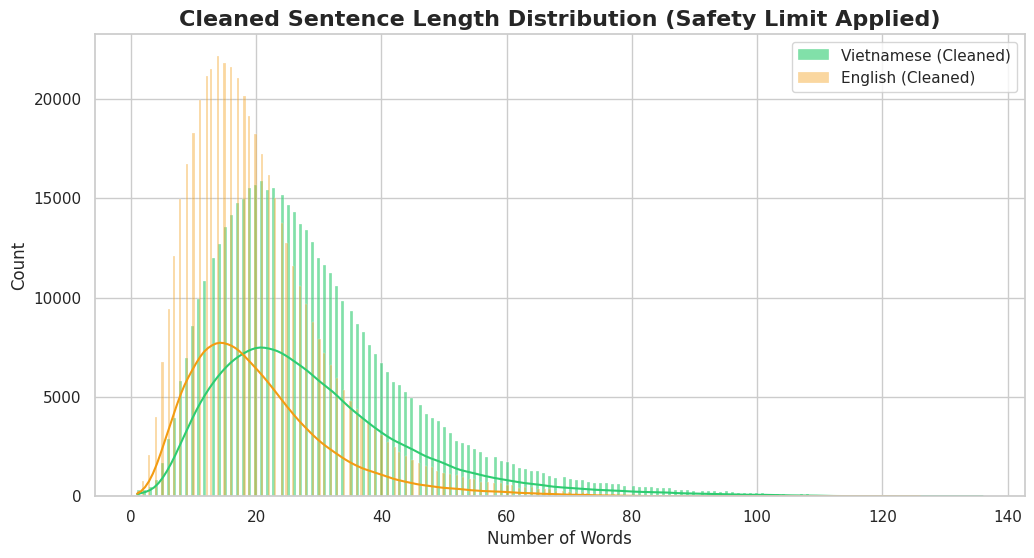

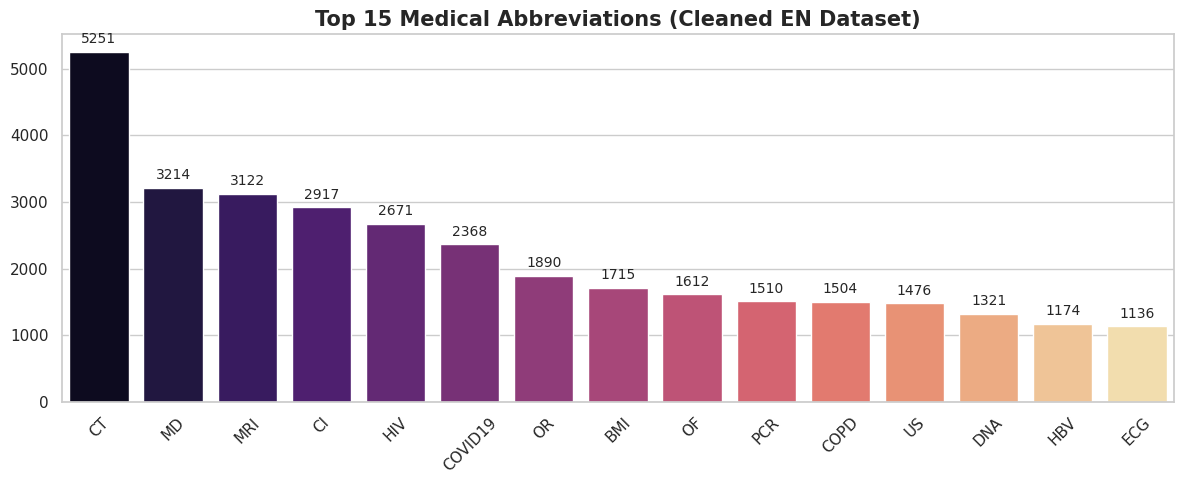

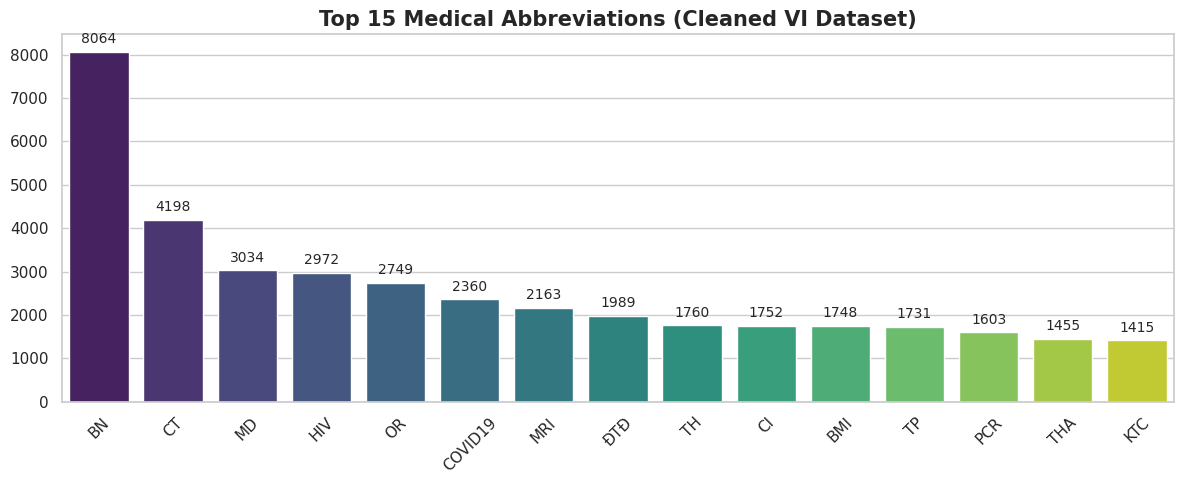


STATISTICAL SUMMARY OF CLEANED DATASET
               Metrics English (Cleaned) Vietnamese (Cleaned)
       Total Sentences            495640               495640
Average Length (words)             20.60                29.24
    Max Length (words)               126                  136
  Unique Abbreviations             14818                13011


In [ ]:
def plot_medical_abbs(abbs, title, palette, filename):
    top_abbs = Counter(abbs).most_common(15)
    words, counts = zip(*top_abbs)
    plt.figure(figsize=(12, 5))
    ax = sns.barplot(x=list(words), y=list(counts), palette=palette, hue=list(words), legend=False)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)
    plt.title(title, fontsize=15, fontweight='bold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

clean_train_en = [d['en'] for d in cleaned_pairs]
clean_train_vi = [d['vi'] for d in cleaned_pairs]

en_lengths_clean, en_abbs_clean = analyze_stats_pro(clean_train_en)
vi_lengths_clean, vi_abbs_clean = analyze_stats_pro(clean_train_vi)

# Chart 2: Cleaned Distribution
plt.figure(figsize=(12, 6))
sns.histplot(vi_lengths_clean, color="#2ecc71", label="Vietnamese (Cleaned)", kde=True, alpha=0.6)
sns.histplot(en_lengths_clean, color="#f39c12", label="English (Cleaned)", kde=True, alpha=0.4)
plt.title("Cleaned Sentence Length Distribution (Safety Limit Applied)", fontsize=16, fontweight='bold')
plt.xlabel("Number of Words")
plt.legend()
plt.show()

# Chart 3 & 4: Abbreviation analysis for Cleaned Data
plot_medical_abbs(en_abbs_clean, "Top 15 Medical Abbreviations (Cleaned EN Dataset)", "magma", "clean_en_abbs.png")
plot_medical_abbs(vi_abbs_clean, "Top 15 Medical Abbreviations (Cleaned VI Dataset)", "viridis", "clean_vi_abbs.png")

# Final Comparison Table
summary_clean = pd.DataFrame({
    "Metrics": ["Total Sentences", "Average Length (words)", "Max Length (words)", "Unique Abbreviations"],
    "English (Cleaned)": [len(clean_train_en), f"{np.mean(en_lengths_clean):.2f}", np.max(en_lengths_clean), len(set(en_abbs_clean))],
    "Vietnamese (Cleaned)": [len(clean_train_vi), f"{np.mean(vi_lengths_clean):.2f}", np.max(vi_lengths_clean), len(set(vi_abbs_clean))]
})

print("\n" + "="*60)
print("STATISTICAL SUMMARY OF CLEANED DATASET")
print("="*60)
print(summary_clean.to_string(index=False))
print("="*60)

# 9. Cấu hình hướng dịch thuật

Chọn hướng dịch thuật cho training:
- `TRAIN_DIRECTION = "en_vi"`: Anh -> Việt (dùng hiện tại)
- `TRAIN_DIRECTION = "vi_en"`: Việt -> Anh (để train chiều ngược)

In [9]:
# Chọn hướng: "en_vi" (Anh->Việt) hoặc "vi_en" (Việt->Anh)
#TRAIN_DIRECTION = "vi_en"
TRAIN_DIRECTION = "en_vi"
print(f"Chế độ Train: {TRAIN_DIRECTION.upper()}")

Chế độ Train: EN_VI


# 10. Hàm tạo Prompt cho Qwen2.5

Định nghĩa hàm `build_prompt()` để tạo prompt theo format chat của Qwen2.5:
- Role "user": Yêu cầu dịch câu (tùy theo TRAIN_DIRECTION)
- Role "assistant": Ground truth (khi training)
- Sử dụng `tokenizer.apply_chat_template()` để format chuẩn

In [10]:
def build_prompt(src_text, tgt_text=None):
    """
    Tạo prompt theo chuẩn chat của Qwen2.5:
    - user: yêu cầu dịch dựa trên TRAIN_DIRECTION
    - assistant: ground truth (tgt_text) nếu training
    """
    # Xác định hướng và tạo prompt tương ứng
    if TRAIN_DIRECTION == "en_vi":
        user_content = f"Dịch câu sau sang tiếng Việt:\n{src_text}"
    else: # vi_en
        user_content = f"Dịch câu sau sang tiếng Anh:\n{src_text}"

    messages = [{"role": "user", "content": user_content}]
    
    if tgt_text is not None:
        messages.append({"role": "assistant", "content": tgt_text})

    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=False
    )

# 11. Đăng nhập HuggingFace

Đăng nhập tài khoản HuggingFace để push/pull models và datasets, cho phép upload private repos

In [ ]:
from huggingface_hub import login

HF_TOKEN = "do chính sách của git nên k được push token"

login(token=HF_TOKEN)
print(">>> Đăng nhập Hugging Face thành công!")

>>> Đăng nhập Hugging Face thành công!


# 12. Tokenize Dataset

Tokenize dữ liệu và lưu/tải từ Hub:
- Tên repo: `yuiyL/qwen2.5-medical-tokenized-{TRAIN_DIRECTION}`
- Hàm `preprocess()`: Áp dụng prompt và tokenize với max_length=512
- Tải từ Hub nếu đã tồn tại, nếu chưa thì tokenize và push

In [12]:
from datasets import load_dataset

HF_USERNAME = "yuiyL"
# Tên Repo Data sẽ đổi theo hướng: ...-tokenized-en-vi HOẶC ...-tokenized-vi-en
TOKENIZED_DATASET_REPO = f"{HF_USERNAME}/qwen2.5-medical-tokenized-{TRAIN_DIRECTION}"
def preprocess(example):
    # Đảo chiều input dựa trên cấu hình
    if TRAIN_DIRECTION == "en_vi":
        src, tgt = example["en"], example["vi"]
    else: # vi_en
        src, tgt = example["vi"], example["en"]

    prompt = build_prompt(src, tgt)
    tokenized = tokenizer(
        prompt,
        truncation=True,
        max_length=512,
        padding=False
    )
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized


print(f">>> Checking tokenized dataset: {TOKENIZED_DATASET_REPO}")

try:
    tokenized_dataset = load_dataset(TOKENIZED_DATASET_REPO)
    print("Loaded tokenized dataset from Hub")

except Exception as e:
    print(f"Tokenized dataset not found for {TRAIN_DIRECTION}. Running tokenization...")

    tokenized_dataset = raw_dataset.map(
        preprocess,
        remove_columns=["en", "vi"],
        desc=f"Tokenizing medical dataset ({TRAIN_DIRECTION})"
    )

    print(">>> Pushing tokenized dataset to Hub")
    tokenized_dataset.push_to_hub(
        TOKENIZED_DATASET_REPO,
        private=True
    )

    print("Tokenized dataset uploaded successfully")

>>> Checking tokenized dataset: yuiyL/qwen2.5-medical-tokenized-en_vi


README.md:   0%|          | 0.00/576 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/74.6M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/74.6M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/7.91M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/922k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/475000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Loaded tokenized dataset from Hub


# 13. Cấu hình LoRA và Resume Training

Thiết lập cấu hình training với PEFT/LoRA:
- Tải `best_state.json` từ Hub để so sánh loss
- Nếu đã có adapter trên Hub: Load và tiếp tục training (resume)
- Nếu chưa: Tạo LoRA config mới
- LoRA config: r=16, alpha=32, dropout=0.05
- Target modules: q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj

In [13]:
import os
import json
import torch
from transformers import TrainingArguments, DataCollatorForSeq2Seq, EarlyStoppingCallback
from peft import LoraConfig, TaskType, PeftModel
from trl import SFTTrainer
from huggingface_hub import HfApi, hf_hub_download

import gc
def reset_cuda():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()


HF_USERNAME = "yuiyL"
# Tên Model cũng đổi theo hướng: ...-sft-en-vi HOẶC ...-sft-vi-en
REPO_NAME = f"qwen2.5-3b-medical-sft-{TRAIN_DIRECTION}"
HUB_MODEL_ID = f"{HF_USERNAME}/{REPO_NAME}"

OUTPUT_DIR = f"qwen2.5-3b-medical-sft-{TRAIN_DIRECTION}"
FINAL_ADAPTER_DIR = f"{OUTPUT_DIR}/final_adapter"
STATE_FILE_NAME = "best_state.json"
LOCAL_STATE_FILE = f"{FINAL_ADAPTER_DIR}/{STATE_FILE_NAME}"
os.makedirs(FINAL_ADAPTER_DIR, exist_ok=True)

api = HfApi()


best_prev_loss = float("inf")
print(f">>> Checking Hub history: {HUB_MODEL_ID}")

try:
    downloaded_path = hf_hub_download(
        repo_id=HUB_MODEL_ID,
        filename=STATE_FILE_NAME,
        local_dir=FINAL_ADAPTER_DIR
    )
    with open(downloaded_path, "r") as f:
        best_prev_loss = json.load(f).get("best_eval_loss", float("inf"))
    print(f"Found previous best loss: {best_prev_loss:.4f}")
except Exception:
    print("No previous record found. Fresh run.")


peft_config = None
has_adapter_on_hub = False

try:
    if "adapter_model.safetensors" in api.list_repo_files(HUB_MODEL_ID):
        has_adapter_on_hub = True
except:
    pass

if has_adapter_on_hub:
    print(">>> RESUME: Loading adapter from Hub")
    model = PeftModel.from_pretrained(model, HUB_MODEL_ID, is_trainable=True)
else:
    print(">>> FRESH START: Initializing new LoRA")
    peft_config = LoraConfig(
        r=16,
        lora_alpha=32,
        lora_dropout=0.05,
        bias="none",
        task_type=TaskType.CAUSAL_LM,
        target_modules=[
            "q_proj", "k_proj", "v_proj",
            "o_proj", "gate_proj", "up_proj", "down_proj"
        ]
    )

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

>>> Checking Hub history: yuiyL/qwen2.5-3b-medical-sft-en_vi


best_state.json:   0%|          | 0.00/38.0 [00:00<?, ?B/s]

Found previous best loss: 1.0425
>>> RESUME: Loading adapter from Hub


adapter_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/120M [00:00<?, ?B/s]

# 14. Cấu hình tham số Training

Thiết lập các tham số huấn luyện: thay đổi theo giai đoạn train
- `VALID_SIZE = 500`, `TRAIN_SIZE = 20000`: Số mẫu train/val
- `MAX_STEPS = 1600`, `EVAL_STEPS = 200`: Số steps đánh giá
- `per_device_train_batch_size = 4`, `gradient_accumulation = 4`: Effective batch = 16
- `learning_rate = 1e-5`, `lr_scheduler_type = "cosine"`, `warmup_steps = 120`
- `bf16`: Mixed precision training
- `load_best_model_at_end = True`: Lưu model tốt nhất

In [ ]:

VALID_SIZE = 500
TRAIN_SIZE = 20000
MAX_STEPS  = 1600
EVAL_STEPS = 200

train_subset = tokenized_dataset["train"].shuffle(seed=42).select(range(TRAIN_SIZE))
valid_subset = tokenized_dataset["validation"].select(range(VALID_SIZE))

data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    pad_to_multiple_of=8,
    padding=True,
    return_tensors="pt"
)

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,

    max_steps=MAX_STEPS,               
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,
    lr_scheduler_type = "cosine",
    warmup_steps=120,   

    per_device_eval_batch_size=2,

    eval_strategy="steps",         
    eval_steps=EVAL_STEPS,             
    save_strategy="steps",             
    save_steps=EVAL_STEPS,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",

    bf16=torch.cuda.is_bf16_supported(),
    fp16=not torch.cuda.is_bf16_supported(),

    logging_steps=50,
    report_to="none",
    remove_unused_columns=False,
    push_to_hub=False
)


# 15. Training và Push model

Thực hiện training và push model lên Hub:
- Khởi tạo `SFTTrainer` với model, datasets, callbacks
- Early stopping với patience=2
- Reset CUDA cache trước khi train
- Sau khi train: so sánh với loss tốt nhất
- Nếu cải thiện: Lưu adapter và push lên Hub với commit message

In [ ]:

trainer = SFTTrainer(
    model=model,
    train_dataset=train_subset,
    eval_dataset=valid_subset,
    args=training_args,
    peft_config=peft_config,
    data_collator=data_collator,
    callbacks=[
        # SafeBleuEvalCallback(tokenizer, test_pairs, num_samples=50),
        EarlyStoppingCallback(early_stopping_patience=2),
    ],
)

print("\nReset CUDA before training")
reset_cuda()

print("\n>>> START TRAINING")
trainer.train()



current_run_best_loss = trainer.state.best_metric
if current_run_best_loss is None:
    current_run_best_loss = trainer.evaluate()["eval_loss"]

print("\n" + "=" * 50)
print(f"Previous best loss : {best_prev_loss:.4f}")
print(f"Current run loss   : {current_run_best_loss:.4f}")

if current_run_best_loss < best_prev_loss:
    print("New model is better. Saving & pushing to Hub.")

    trainer.save_model(FINAL_ADAPTER_DIR)
    tokenizer.save_pretrained(FINAL_ADAPTER_DIR)

    with open(LOCAL_STATE_FILE, "w") as f:
        json.dump({"best_eval_loss": current_run_best_loss}, f)

    api.upload_folder(
        folder_path=FINAL_ADAPTER_DIR,
        repo_id=HUB_MODEL_ID,
        repo_type="model",
        commit_message=f"Upgrade: loss {current_run_best_loss:.4f}"
    )

    print(f"Updated model: https://huggingface.co/{HUB_MODEL_ID}")
else:
    print("Model not improved. Skip pushing.")

print("=" * 50)


#  16. Vẽ biểu đồ Training Metrics

Vẽ các biểu đồ visualize quá trình training:
- Hàm `plot_training_metrics()`: Vẽ train_loss và val_loss theo steps
- Hiển thị giá trị loss tại mỗi checkpoint
- Đánh dấu "Best Model" (validation loss thấp nhất)
- Vẽ 4 kịch bản:
  - EN-VI: Convergence tốt
  - EN-VI: Overfitting
  - VI-EN: Convergence tốt
  - VI-EN: Non-improving

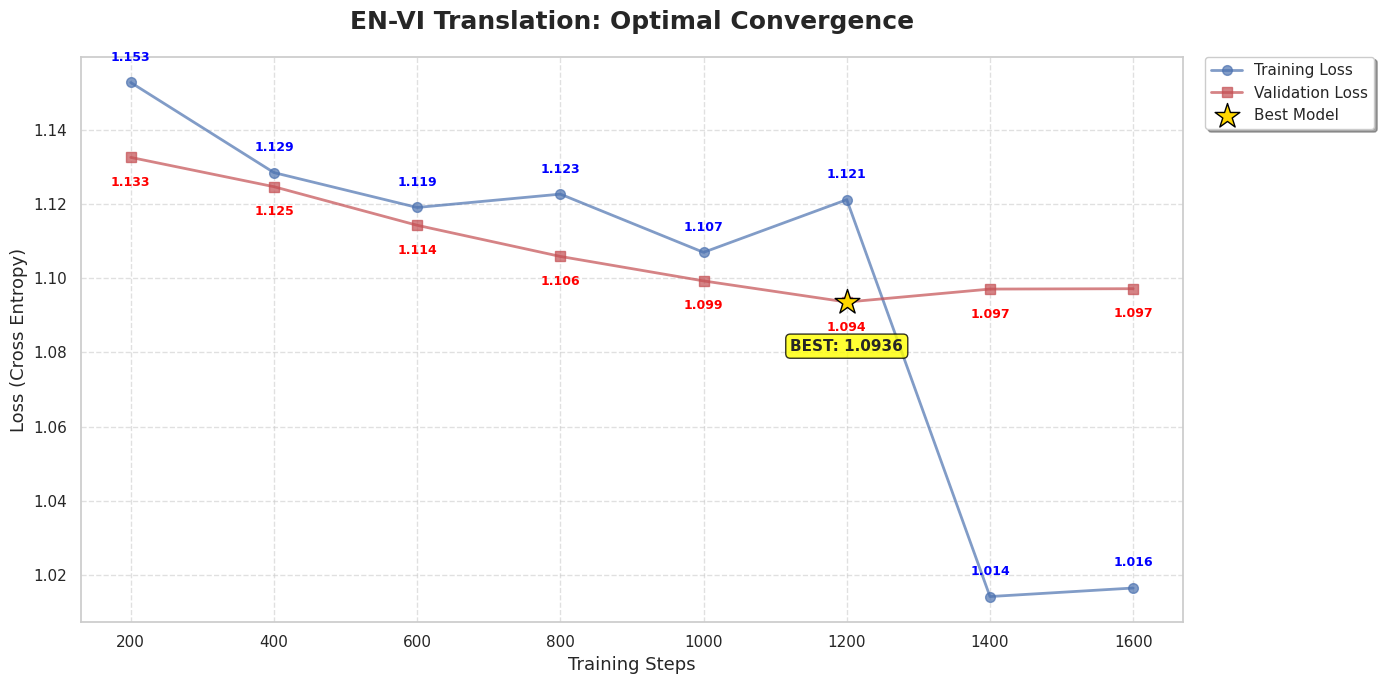

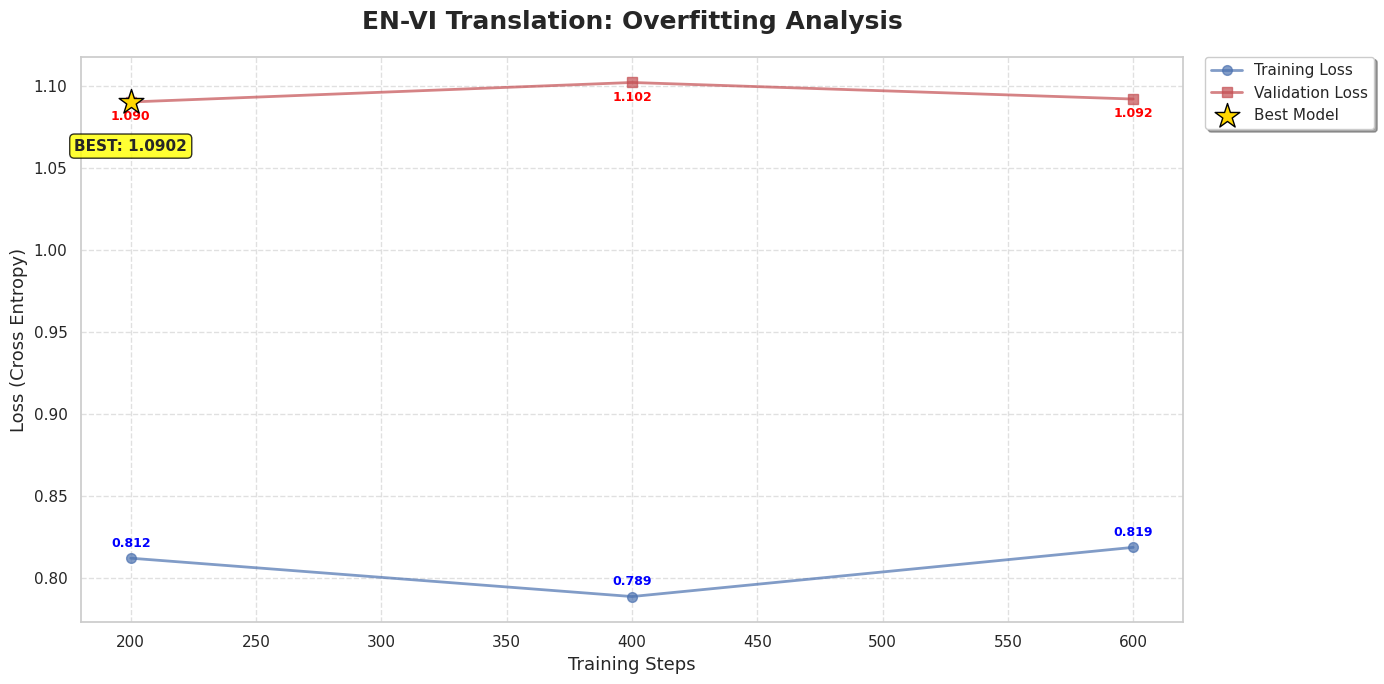

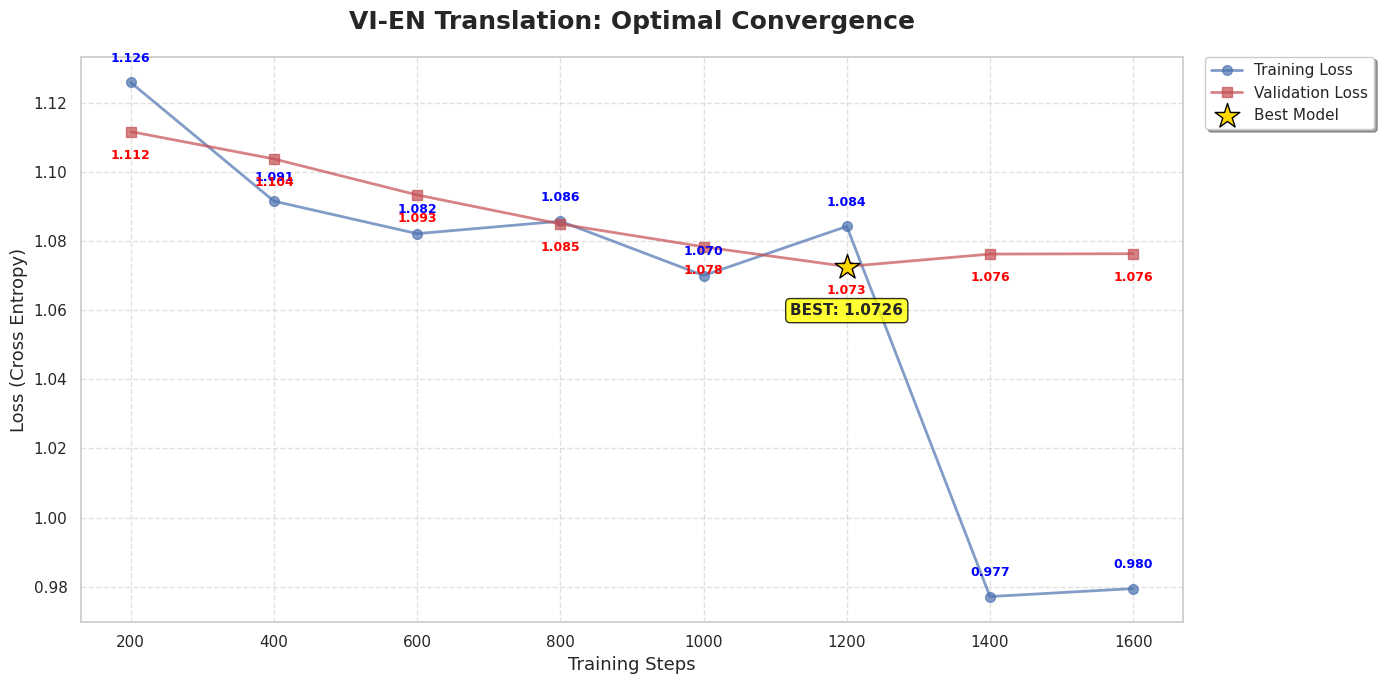

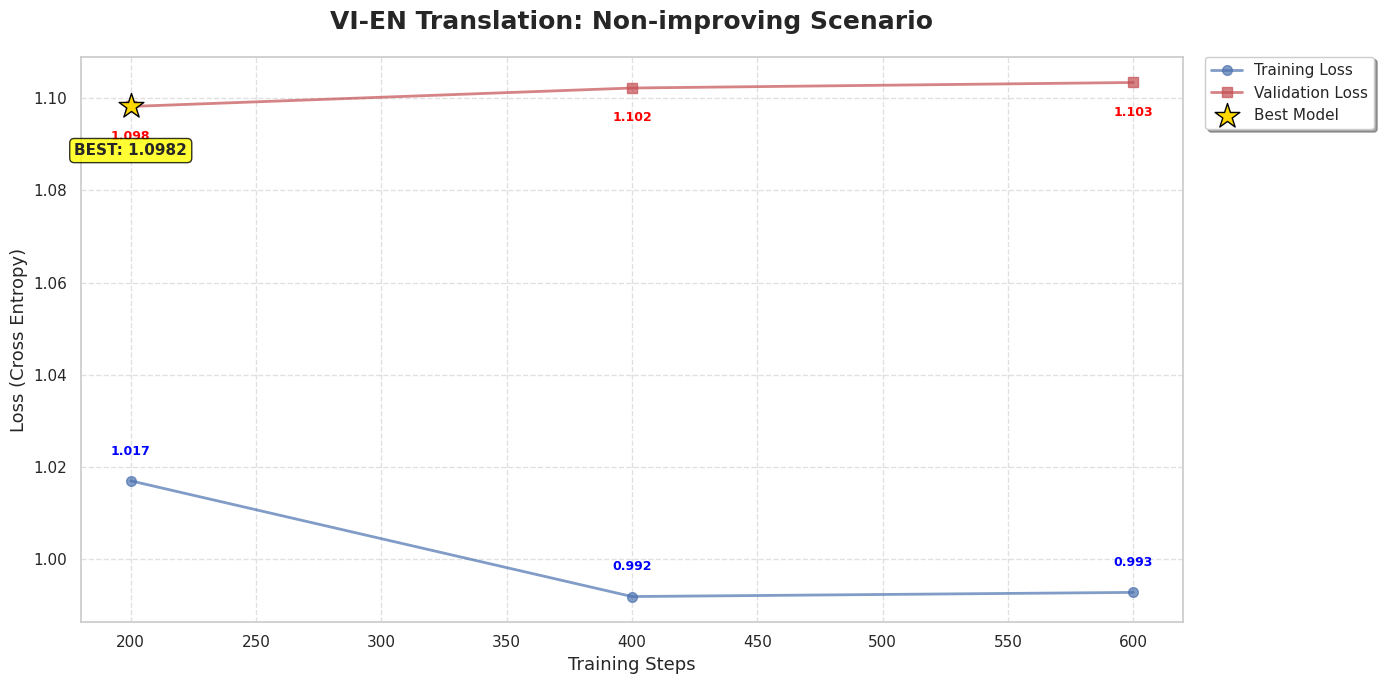

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập phong cách academic
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

def plot_training_metrics(steps, train_loss, val_loss, title, filename):
    fig, ax = plt.subplots()
    
    line1, = ax.plot(steps, train_loss, 'b-o', label='Training Loss', linewidth=2, markersize=7, alpha=0.7)
    line2, = ax.plot(steps, val_loss, 'r-s', label='Validation Loss', linewidth=2, markersize=7, alpha=0.7)
    
    for i, (s, tl, vl) in enumerate(zip(steps, train_loss, val_loss)):
        ax.text(s, tl + 0.005, f'{tl:.3f}', color='blue', ha='center', va='bottom', fontsize=9, fontweight='bold')
        ax.text(s, vl - 0.005, f'{vl:.3f}', color='red', ha='center', va='top', fontsize=9, fontweight='bold')
    
    min_val_loss = min(val_loss)
    idx_min = val_loss.index(min_val_loss)
    best_step = steps[idx_min]
    
    ax.scatter(best_step, min_val_loss, color='gold', s=350, marker='*', 
               edgecolors='black', zorder=10, label=f'Best Model')
    
    ax.annotate(f'BEST: {min_val_loss:.4f}', 
                xy=(best_step, min_val_loss),
                xytext=(0, -35), 
                textcoords='offset points',
                ha='center',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", alpha=0.8))

    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Training Steps', fontsize=13)
    ax.set_ylabel('Loss (Cross Entropy)', fontsize=13)
    
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=True, shadow=True)
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout() 
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# EN-VI
steps_envi_good = [200, 400, 600, 800, 1000, 1200, 1400, 1600]
train_envi_good = [1.1528, 1.1285, 1.1191, 1.1227, 1.1070, 1.1212, 1.0142, 1.0165]
val_envi_good = [1.1326, 1.1247, 1.1143, 1.1059, 1.0993, 1.0936, 1.0971, 1.0972]

steps_envi_over = [200, 400, 600]
train_envi_over = [0.8120, 0.7886, 0.8186]
val_envi_over = [1.0902, 1.1021, 1.0920]

# VI-EN
steps_vien_good = [200, 400, 600, 800, 1000, 1200, 1400, 1600]
train_vien_good = [1.1258, 1.0915, 1.0821, 1.0857, 1.0700, 1.0842, 0.9772, 0.9795]
val_vien_good = [1.1116, 1.1037, 1.0933, 1.0849, 1.0783, 1.0726, 1.0762, 1.0763]

steps_vien_bad = [200, 400, 600]
train_vien_bad = [1.0170, 0.9919, 0.9928]
val_vien_bad = [1.0982, 1.1022, 1.1034]

plot_training_metrics(steps_envi_good, train_envi_good, val_envi_good, "EN-VI Translation: Optimal Convergence", "envi_good_v2.png")
plot_training_metrics(steps_envi_over, train_envi_over, val_envi_over, "EN-VI Translation: Overfitting Analysis", "envi_overfit_v2.png")
plot_training_metrics(steps_vien_good, train_vien_good, val_vien_good, "VI-EN Translation: Optimal Convergence", "vien_good_v2.png")
plot_training_metrics(steps_vien_bad, train_vien_bad, val_vien_bad, "VI-EN Translation: Non-improving Scenario", "vien_bad_v2.png")

# 17. Cấu hình đánh giá mô hình

Thiết lập cấu hình cho việc dịch và đánh giá:
- `UPDATE_ALL_TEST = False`: Chỉ load dữ liệu cũ (không dịch lại)
- `TEST_REPO_ID`: Repo chứa kết quả dịch
- `FILE_EN_VI`, `FILE_VI_EN`: Tên file cho từng chiều dịch

In [ ]:
UPDATE_ALL_TEST = False  # True: Dịcah lại 3000 câu bằng model hiện tại | False: Chỉ load file cũ
TEST_REPO_ID = f"{HF_USERNAME}/medical-test-results" # Tên repo chứa kết quả dịch

# Tên file cho từng chiều
FILE_EN_VI = "test_results_en_vi.parquet"
FILE_VI_EN = "test_results_vi_en.parquet"

print(f">>> Hướng huấn luyện chính: {TRAIN_DIRECTION.upper()}")
print(f">>> Chế độ cập nhật: {'BẮT ĐẦU DỊCH VÀ GHI ĐÈ' if UPDATE_ALL_TEST else 'CHỈ LOAD DỮ LIỆU ĐÃ LƯU'}")

>>> Hướng huấn luyện chính: EN_VI
>>> Chế độ cập nhật: CHỈ LOAD DỮ LIỆU ĐÃ LƯU


# 18. Dịch và lưu kết quả Test

Hàm `get_or_update_translations()` để dịch test set:
1. Tải file parquet từ Hub (nếu có)
2. Nếu cần update hoặc chưa có:
   - Dịch 3000 câu với cả Base và Fine-tuned model
   - Sử dụng `model.disable_adapter()` để tắt LoRA
   - Backup mỗi 100 câu để tránh mất dữ liệu
   - Lưu và push toàn bộ lên Hub

In [ ]:
import torch
import pandas as pd
from huggingface_hub import hf_hub_download, upload_file
from tqdm import tqdm

def get_or_update_translations(model, tokenizer, dataset, direction, update=False):
    filename = FILE_EN_VI if direction == "en_vi" else FILE_VI_EN
    df_results = None
    
    try:
        path = hf_hub_download(repo_id=TEST_REPO_ID, filename=filename, repo_type="dataset")
        df_results = pd.read_parquet(path)
        print(f"Đã tải file kết quả cũ của {direction.upper()} ({len(df_results)} câu)")
    except:
        print(f"ℹChưa có dữ liệu cũ cho chiều {direction.upper()} trên Hub.")

    # 2. Nếu update=True hoặc chưa có file -> Thực hiện dịch
    if update or df_results is None:
        print(f"Đang tiến hành dịch 3000 câu cho chiều {direction.upper()}...")
        src_key = "en" if direction == "en_vi" else "vi"
        tgt_key = "vi" if direction == "en_vi" else "en"
        prompt_tpl = "Dịch câu sau sang tiếng Việt:\n{}" if direction == "en_vi" else "Dịch câu sau sang tiếng Anh:\n{}"
        
        # Giới hạn 3000 mẫu
        samples = dataset.select(range(min(3000, len(dataset))))
        data = {"source": [], "reference": [], "base_model": [], "fine_tuned": []}

        model.eval()
        for i, item in enumerate(tqdm(samples, desc=f"Translating {direction.upper()}")):
            src_text, ref_text = item[src_key], item[tgt_key]
            
            data["source"].append(src_text)
            data["reference"].append(ref_text)
            
            messages = [{"role": "user", "content": prompt_tpl.format(src_text)}]
            inputs = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to(model.device)

            with torch.no_grad():
                # Dịch bằng Base Model (Tắt adapter)
                with model.disable_adapter():
                    out_base = model.generate(inputs, max_new_tokens=512, do_sample=False)
                    data["base_model"].append(tokenizer.decode(out_base[0][len(inputs[0]):], skip_special_tokens=True).strip())
                
                # Dịch bằng Fine-tuned Model (Bật adapter)
                out_ft = model.generate(inputs, max_new_tokens=512, do_sample=False)
                data["fine_tuned"].append(tokenizer.decode(out_ft[0][len(inputs[0]):], skip_special_tokens=True).strip())
            
            if (i + 1) % 100 == 0:
                df_temp = pd.DataFrame(data)
                df_temp.to_parquet(filename)
                try:
                    upload_file(
                        path_or_fileobj=filename, 
                        path_in_repo=filename, 
                        repo_id=TEST_REPO_ID, 
                        repo_type="dataset",
                        commit_message=f"Incremental update: {i+1} samples translated"
                    )
                    print(f"\nĐã sao lưu {i+1} bản dịch lên Hub.")
                except Exception as e:
                    print(f"\nLỗi khi đẩy bản sao lưu (vẫn tiếp tục): {e}")

        df_results = pd.DataFrame(data)
        df_results.to_parquet(filename)
        upload_file(path_or_fileobj=filename, path_in_repo=filename, repo_id=TEST_REPO_ID, repo_type="dataset")
        print(f"HOÀN THÀNH: Đã dịch và upload toàn bộ {len(df_results)} câu.")

    return df_results

test_data = raw_dataset["test"]
current_df = get_or_update_translations(model, tokenizer, test_data, TRAIN_DIRECTION, update=UPDATE_ALL_TEST)

test_results_en_vi.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

✅ Đã tải file kết quả cũ của EN_VI (3000 câu)


# 19. Đánh giá BLEU Score

Đánh giá chất lượng dịch thuật bằng SacreBLEU:
- Hàm `clean_medical_text()`: Làm sạch text base model (loại bỏ chatter)
- Hàm `calculate_all_metrics()`: Tính BLEU cho base và fine-tuned
- Vẽ biểu đồ so sánh Base vs Fine-tuned cho cả 2 chiều
- Hiển thị mức cải thiện (improvement)


📊 BÁO CÁO SO SÁNH HIỆU NĂNG ĐA CHIỀU (BLEU SCORE)
| Direction | BASE(Raw) | FINE-TUNED | Imp (vs Raw) |
|-----------|-----------|------------|--------------|
| EN -> VI  |     17.13 |      42.47 |        25.34 |


test_results_vi_en.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

| VI -> EN  |     12.27 |      32.99 |        20.72 |
(*) BASE(Raw): Điểm thực tế của mô hình gốc (bao gồm cả chatter).

Drawing comparison chart...


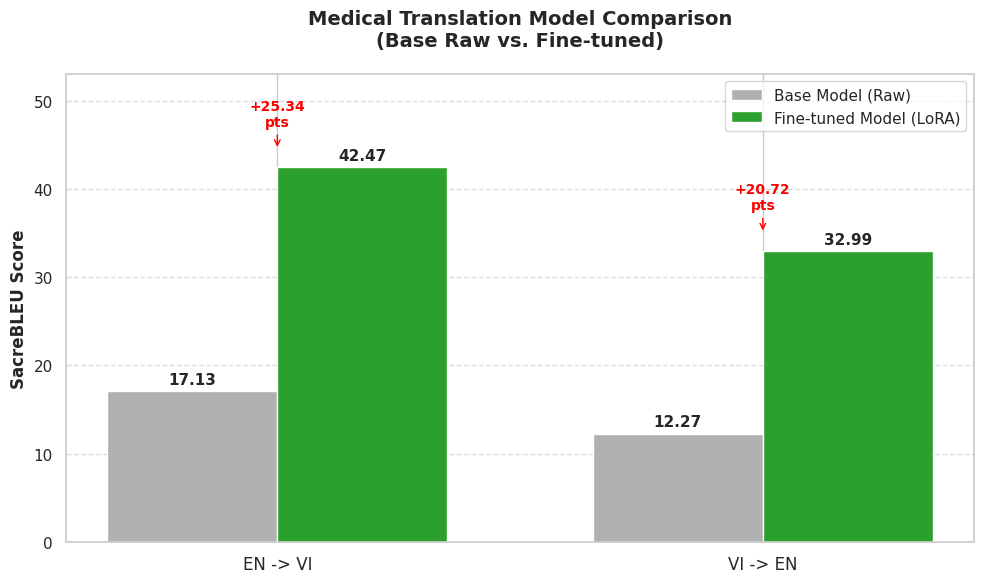

In [ ]:
import sacrebleu
import pandas as pd
from huggingface_hub import hf_hub_download
import re
import matplotlib.pyplot as plt
import numpy as np


def clean_medical_text(text):
    if not isinstance(text, str): return ""
    # Tìm nội dung nằm trong dấu ngoặc kép (trường hợp Base bọc bản dịch)
    matches = re.findall(r'"([^"]*)"', text)
    if matches:
        return max(matches, key=len)
    # Loại bỏ câu dẫn "Here's the English translation..."
    text = re.sub(r"(?i)Here's the English translation.*:\s*", "", text)
    return text.strip()

def calculate_all_metrics(df):
    if df is None: return 0.0, 0.0, 0.0
    
    refs = [df["reference"].tolist()]
    ft_list = df["fine_tuned"].tolist()
    base_raw_list = df["base_model"].tolist()
    
    # Method 1: Cleaned + Smoothed (Đánh giá nội tại lõi dịch thuật)
    base_cleaned = [clean_medical_text(t) for t in base_raw_list]
    score_base_cleaned = sacrebleu.corpus_bleu(base_cleaned, refs, smooth_method='exp').score
    
    # Method 2: Raw (Đánh giá thực tế trải nghiệm người dùng)
    score_base_raw = sacrebleu.corpus_bleu(base_raw_list, refs).score
    
    # Fine-tuned score (Luôn dùng raw vì FT phải sạch rác)
    score_ft = sacrebleu.corpus_bleu(ft_list, refs).score
    
    return score_base_raw, score_base_cleaned, score_ft

def plot_results(data):
    directions = data['directions']
    base_scores = data['base_raw']
    ft_scores = data['ft']
    
    x = np.arange(len(directions))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, base_scores, width, label='Base Model (Raw)', color='#B0B0B0')
    rects2 = ax.bar(x + width/2, ft_scores, width, label='Fine-tuned Model (LoRA)', color='#2ca02c')

    # Thiết lập nhãn và tiêu đề tiếng Anh
    ax.set_ylabel('SacreBLEU Score', fontsize=12, fontweight='bold')
    ax.set_title('Medical Translation Model Comparison\n(Base Raw vs. Fine-tuned)', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(directions, fontsize=12)
    ax.legend()
    
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)

    # Hàm hiển thị số liệu trên cột
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=11, fontweight='bold')

    autolabel(rects1)
    autolabel(rects2)

    # Hiển thị mức cải thiện (Improvement)
    for i in range(len(directions)):
        if base_scores[i] > 0:
            improvement = ft_scores[i] - base_scores[i]
            center_x = x[i]
            max_y = max(base_scores[i], ft_scores[i])
            
            ax.annotate(f'+{improvement:.2f}\npts',
                        xy=(center_x, max_y + 2),
                        xytext=(0, 15),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=10, color='red', fontweight='bold',
                        arrowprops=dict(arrowstyle='->', connectionstyle="arc3", color='red'))

    plt.ylim(0, max(ft_scores) * 1.25) 
    plt.tight_layout()
    plt.show()


def full_report_and_plot():
    print("\n" + "="*75)
    print("BÁO CÁO SO SÁNH HIỆU NĂNG ĐA CHIỀU (BLEU SCORE)")
    print("="*75)
    print(f"| Direction | BASE(Raw) | FINE-TUNED | Imp (vs Raw) |")
    print("|-----------|-----------|------------|--------------|")

    # Lưu dữ liệu để vẽ biểu đồ
    plot_data = {
        "directions": [],
        "base_raw": [],
        "ft": []
    }

    file_list = [
        (FILE_EN_VI, "EN -> VI"), 
        (FILE_VI_EN, "VI -> EN")
    ]

    for file_name, direction in file_list:
        try:
            path = hf_hub_download(repo_id=TEST_REPO_ID, filename=file_name, repo_type="dataset")
            df = pd.read_parquet(path)
            raw, cleaned, ft = calculate_all_metrics(df)
            
            imp = ft - raw
            print(f"| {direction:9} | {raw:9.2f} | {ft:10.2f} | {imp:12.2f} |")
            
            plot_data["directions"].append(direction)
            plot_data["base_raw"].append(raw)
            plot_data["ft"].append(ft)

        except Exception as e:
            print(f"| {direction:9} |    Error  |    Error    |    Error    |      -        |")
            print(f"Error details: {e}")

    print("="*75)
    print("(*) BASE(Raw): Điểm thực tế của mô hình gốc (bao gồm cả chatter).")
    
    # Gọi hàm vẽ biểu đồ nếu có dữ liệu
    if plot_data["directions"]:
        print("\nDrawing comparison chart...")
        plot_results(plot_data)
    else:
        print("\nNo data available to plot.")

# Chạy hàm
full_report_and_plot()

# 20. Cài đặt Google GenAI

Cài đặt thư viện cần thiết cho việc đánh giá bằng Gemini:
- `google-genai`: API client cho Google Gemini
- `sacrebleu`: Đã cài nhưng có thể update

In [19]:
!pip install -q -U google-genai sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.6/426.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 11.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.45.0 which is incompatible.
google-colab 1.0.0 requires jupyter-server==2.14.0, but you have jupyter-server 2.12.5 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
bigframes 2.26.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.10.0 which is in

# 21. Cấu hình API Keys cho Gemini

Thiết lập cấu hình cho việc đánh giá bằng Google Gemini:
- `TEST_REPO_ID`: Repo chứa kết quả trên Hub
- `API_KEYS`: Danh sách 8 API keys để rotate (tránh rate limit)
- `FILE_RESULTS_MAP`: Tên file kết quả cho từng chiều
- `test_data`: Dataset test từ raw_dataset

In [ ]:
import pandas as pd
import json
import time
import os
from tqdm import tqdm
from huggingface_hub import hf_hub_download, upload_file, list_repo_files
from google import genai

TEST_REPO_ID = "yuiyL/medical-test-results"
API_KEYS = ["do chính sách của git nên k được push token"
]
test_data = raw_dataset["test"]
FILE_RESULTS_MAP = {
    "en_vi": "gemini_dual_eval_en_vi.parquet",
    "vi_en": "gemini_dual_eval_vi_en.parquet"
}



# 22. Hàm chấm điểm bằng Gemini

Định nghĩa hàm `get_dual_gemini_scores()` để chấm điểm:
- Prompt yêu cầu Gemini đóng vai "Chuyên gia Thẩm định Dịch thuật Y khoa"
- Chấm điểm 0-100 cho cả Base và Fine-tuned
- Tiêu chí chấm:
  - Độ chính xác y khoa (~50%)
  - Bỏ sót thông tin (Omission)
  - Thuật ngữ chuyên ngành (~30%)
  - Văn phong (~20%)
- Trừ điểm cứng cho: chatter, lỗi an toàn y tế, cụm từ mơ hồ
- Trả về JSON format với: base_score, ft_score, reason
- Thử cả `gemini-2.0-flash` và `gemini-2.0-flash-lite`
- Auto rotate API keys khi gặp lỗi 429

In [1]:
def get_dual_gemini_scores(batch_items, api_keys, api_idx, src_lang, tgt_lang):
    current_key = api_keys[api_idx % len(api_keys)]
    client = genai.Client(api_key=current_key)
    
    num_items = len(batch_items)
    items_prompt = ""
    for idx, item in enumerate(batch_items):
        items_prompt += f"\n--- Cặp {idx+1} ---\nGốc: {item['src']}\nTham chiếu: {item['ref']}\nBản dịch A (Base): {item['base']}\nBản dịch B (Fine-tuned): {item['ft']}\n"

    prompt = f"""
Bạn là Chuyên gia Thẩm định Dịch thuật Y khoa cao cấp (Senior Medical Translation Auditor),
có kinh nghiệm đánh giá dịch thuật lâm sàng và nghiên cứu y sinh.

Bạn sẽ đánh giá ĐỘC LẬP từng cặp bản dịch từ {src_lang} sang {tgt_lang}.
Mỗi cặp gồm:
- Gốc: câu nguồn
- Tham chiếu: bản dịch chuẩn (reference)
- Bản dịch A: Base model
- Bản dịch B: Fine-tuned model

Nhiệm vụ của bạn là:
- Chấm điểm RIÊNG cho Bản dịch A và Bản dịch B so với Tham chiếu
- So sánh chất lượng y khoa giữa A và B trong cùng một nhận xét
- Tập trung vào độ chính xác, độ an toàn y khoa và tính học thuật

THANG ĐIỂM & LUẬT CHẤM (BẮT BUỘC TUÂN THỦ – KHÔNG SUY DIỄN THÊM)

Mỗi bản dịch được chấm từ 0–100 điểm.

1. ĐỘ CHÍNH XÁC Y KHOA (≈50%)
- Sai bệnh, thuốc, giải phẫu, liều lượng, chỉ dẫn lâm sàng ảnh hưởng an toàn → TRỪ 40 ĐIỂM
- Sai thuật ngữ y khoa KHÔNG ảnh hưởng trực tiếp an toàn → trừ 15–25 điểm
- Diễn đạt lệch nhẹ ý y khoa → trừ 5–10 điểm

2. BỎ SÓT THÔNG TIN (OMISSION)
- Omission nhẹ, không ảnh hưởng quyết định y khoa → trừ 5–10 điểm
- Omission trung bình (thiếu thông tin hỗ trợ) → trừ 15 điểm
- Omission nghiêm trọng (thiếu chẩn đoán, đối tượng, liều, điều kiện lâm sàng) → trừ 30–40 điểm

3. THUẬT NGỮ CHUYÊN NGÀNH (≈30%)
- Dùng từ phổ thông thay cho thuật ngữ lâm sàng → trừ 10–15 điểm
- Thuật ngữ chuẩn, nhất quán → không trừ điểm

4. VĂN PHONG & TÍNH LƯU LOÁT (≈20%)
- Văn phong khoa học, trung lập → không trừ
- Dài dòng, thiếu trang trọng → trừ 5–10 điểm

--------------------------------------------------------------------
QUY TẮC TRỪ ĐIỂM CỨNG (BẮT BUỘC):
- Có chatter / rác ngôn ngữ (“Sure, here is…”, “Bản dịch là…”) → trừ 10 điểm
- Lỗi nghiêm trọng ảnh hưởng trực tiếp an toàn y tế → trừ 40 điểm
- Cụm danh từ y khoa mơ hồ, dễ gây hiểu lầm lâm sàng → trừ 20 điểm
- MỖI LỖI CHỈ TRỪ MỘT LẦN THEO MỨC CAO NHẤT (KHÔNG CỘNG DỒN)

--------------------------------------------------------------------
THANG ĐIỂM NEO (PHẢI TUÂN THEO):
- 95–100: Chính xác, thuật ngữ chuẩn, văn phong khoa học
- 90–94: Lỗi rất nhỏ, không ảnh hưởng y khoa
- 80–89: Lỗi nhẹ, cần chỉnh sửa
- 60–79: Lỗi đáng chú ý, cần hậu kiểm
- <60: Không chấp nhận trong dịch thuật y khoa

CÁCH VIẾT CỘT reason (BẮT BUỘC):
- Chỉ rõ lỗi hoặc ưu điểm Y KHOA CỤ THỂ
- So sánh Base và Fine-tuned trong CÙNG MỘT nhận xét
- Ngắn gọn, kỹ thuật, không nhận xét chung chung

Ví dụ hợp lệ:
“Base sai thuật ngữ ‘X’ → ‘Y’ (−40, ảnh hưởng an toàn); FT dùng đúng thuật ngữ chuẩn, văn phong gọn.”

ĐỊNH DẠNG TRẢ VỀ (CHỈ JSON – KHÔNG TEXT KHÁC):

{{
  "results": [
    {{
      "base_score": int,
      "ft_score": int,
      "reason": "string"
    }}
  ]
}}

Số phần tử trong "results" PHẢI BẰNG số cặp dữ liệu được cung cấp.

DỮ LIỆU ĐÁNH GIÁ:
{items_prompt}
"""


    for model_id in ["models/gemini-2.0-flash", "models/gemini-2.0-flash-lite"]:
        try:
            response = client.models.generate_content(model=model_id, contents=prompt)
            text = response.text.strip()
            if "```json" in text: text = text.split("```json")[1].split("```")[0].strip()
            elif "```" in text: text = text.replace("```", "").strip()
            
            data = json.loads(text)
            results = data.get("results", [])
            if len(results) == num_items: return results, api_idx
        except Exception as e:
            if "429" in str(e):
                print(f"🔄 Đổi Key tại index {api_idx % len(api_keys)}")
                return get_dual_gemini_scores(batch_items, api_keys, api_idx + 1, src_lang, tgt_lang)
            continue
    return [{"base_score": None, "ft_score": None, "reason": "Error"}] * num_items, api_idx


# 23. Hàm chạy đánh giá Gemini

Định nghĩa hàm `run_gemini_comparison_eval()`:
1. **Check Hub**: Tìm kiếm file kết quả trên Hub
2. **Chuẩn bị dữ liệu**: Lọc câu theo độ dài (>= min_words), shuffle
3. **Chấm điểm**: Gọi API theo batch (batch_size=4)
4. **Lưu và push**: Lưu parquet và push lên Hub

In [ ]:
def run_gemini_comparison_eval(direct="en_vi", num_samples=100, min_words=15):
    target_file = FILE_RESULTS_MAP[direct]
    
    try:
        print(f"Đang kiểm tra file '{target_file}' trên Hub...")
        repo_files = list_repo_files(repo_id=TEST_REPO_ID, repo_type="dataset")
        if target_file in repo_files:
            print(f"Đã có kết quả trên Hub. Đang tải về...")
            path = hf_hub_download(repo_id=TEST_REPO_ID, filename=target_file, repo_type="dataset")
            return pd.read_parquet(path)
    except Exception as e:
        print(f"Chưa có file trên Hub hoặc lỗi kết nối: {e}")

    print(f"Bắt đầu đánh giá mới cho hướng {direct}...")
    
    # Chuyển test_data sang Pandas để dễ lọc (giả sử test_data là HF Dataset)
    if hasattr(test_data, "to_pandas"):
        df = test_data.to_pandas()
    else:
        df = pd.DataFrame(test_data)

    # Lọc câu theo độ dài min_words
    df_filtered = df[df['source'].str.split().str.len() >= min_words].copy()
    
    if len(df_filtered) < num_samples:
        print(f"Chỉ tìm thấy {len(df_filtered)} câu đủ tiêu chuẩn. Chấm tất cả.")
        num_samples = len(df_filtered)

    # Shuffle và lấy mẫu
    sampled_df = df_filtered.sample(n=num_samples, random_state=42).copy()
    
    src_lang = "Tiếng Anh" if direct == "en_vi" else "Tiếng Việt"
    tgt_lang = "Tiếng Việt" if direct == "en_vi" else "Tiếng Anh"
    
    items_to_score = [
        {"src": r["source"], "ref": r["reference"], "base": r["base_model"], "ft": r["fine_tuned"]}
        for _, r in sampled_df.iterrows()
    ]

    all_results = []
    api_idx = 0
    batch_size = 4 

    for i in tqdm(range(0, len(items_to_score), batch_size), desc=f"Gemini Eval {direct}"):
        batch = items_to_score[i:i+batch_size]
        results, api_idx = get_dual_gemini_scores(batch, API_KEYS, api_idx, src_lang, tgt_lang)
        all_results.extend(results)
        time.sleep(2) 

    sampled_df["base_score"] = [r.get("base_score") for r in all_results]
    sampled_df["ft_score"] = [r.get("ft_score") for r in all_results]
    sampled_df["reason"] = [r.get("reason") for r in all_results]

    sampled_df.to_parquet(target_file)
    try:
        upload_file(
            path_or_fileobj=target_file,
            path_in_repo=target_file,
            repo_id=TEST_REPO_ID,
            repo_type="dataset"
        )
        print(f"Đã push kết quả lên Hub: {target_file}")
    except Exception as e:
        print(f"Lỗi push Hub: {e}")

    return sampled_df


# 24. Thực thi đánh giá Gemini

Chạy đánh giá cho cả 2 chiều dịch:
- `df_results_en_vi`: Kết quả đánh giá EN -> VI (3000 mẫu)
- `df_results_vi_en`: Kết quả đánh giá VI -> EN (3000 mẫu)
- Hiển thị 5 kết quả đầu tiên của VI -> EN

In [22]:
df_results_en_vi = run_gemini_comparison_eval(direct="en_vi", num_samples=3000)
df_results_vi_en = run_gemini_comparison_eval(direct="vi_en", num_samples=3000)

df_results_vi_en.head(5)

🔍 Đang kiểm tra file 'gemini_dual_eval_en_vi.parquet' trên Hub...
✅ Đã có kết quả trên Hub. Đang tải về...


gemini_dual_eval_en_vi.parquet:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

🔍 Đang kiểm tra file 'gemini_dual_eval_vi_en.parquet' trên Hub...
✅ Đã có kết quả trên Hub. Đang tải về...


gemini_dual_eval_vi_en.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

,source,reference,base_model,fine_tuned,base_score,ft_score,reason
0,Thực trạng kiến thức và thực hành của người có...,"Knowledge, practices in public health service ...",Here's the English translation of the given Vi...,Knowledge and practice of people with health i...,75.0,65.0,Base: Omission mức trung bình (thiếu thông tin...
1,"Mô tả thực trạng kiến thức, thực hành của ngườ...","Describe knowledge, practices in public health...",Here's the English translation of the given Vi...,Describe the current status of knowledge and p...,55.0,85.0,Base: Omission nghiêm trọng (thiếu ý quan trọn...
2,Phương pháp: Thiết kế nghiên mô tả cắt ngang đ...,Methodology: A cross sectional study was used ...,Here's the English translation of the given Vi...,Methods: A cross-sectional study was conducted...,75.0,65.0,Base: Omission mức trung bình (thiếu thông tin...
3,Kết quả: Tỷ lệ người biết được khám chữa bệnh ...,Results: Percentage of card's holders who knew...,Here's the English translation of the given Vi...,Results: The percentage of people who knew tha...,55.0,65.0,Base và FT: Omission nghiêm trọng (thiếu ý qua...
4,Tỷ lệ người có thẻ BHYT thực hành khám chữa bệ...,Percentage of card's holders who went to the f...,The percentage of people with a Health Insuran...,The proportion of people with health insurance...,65.0,65.0,Base và FT: Omission nghiêm trọng (thiếu ý qua...


# 25. Tổng hợp điểm số Gemini

Hàm `get_summary_scores()` tổng hợp kết quả:
- Tính điểm trung bình cho Base và Fine-tuned theo từng chiều
- Tính % cải thiện
- Hiển thị bảng so sánh đẹp mắt với markdown format

In [ ]:
import pandas as pd

def get_summary_scores(df_en_vi, df_vi_en):
    # Tính điểm trung bình cho hướng EN -> VI
    en_vi_base = df_en_vi['base_score'].mean()
    en_vi_ft = df_en_vi['ft_score'].mean()
    
    # Tính điểm trung bình cho hướng VI -> EN
    vi_en_base = df_vi_en['base_score'].mean()
    vi_en_ft = df_vi_en['ft_score'].mean()
    
    # Tạo DataFrame tổng hợp để hiển thị đẹp mắt
    summary_data = {
        "Hướng dịch": ["Anh -> Việt (EN-VI)", "Việt -> Anh (VI-EN)"],
        "Base Model (Điểm TB)": [f"{en_vi_base:.2f}", f"{vi_en_base:.2f}"],
        "Fine-tuned (Điểm TB)": [f"{en_vi_ft:.2f}", f"{vi_en_ft:.2f}"],
        "Cải thiện (%)": [
            f"{((en_vi_ft - en_vi_base)/en_vi_base * 100):.2f}%",
            f"{((vi_en_ft - vi_en_base)/vi_en_base * 100):.2f}%"
        ]
    }
    
    return pd.DataFrame(summary_data)

# Thực thi và hiển thị
summary_df = get_summary_scores(df_results_en_vi, df_results_vi_en)
print("BẢNG SO SÁNH ĐIỂM GEMINI SCORE TỔNG KẾT:")
print("-" * 60)
print(summary_df.to_markdown(index=False))

📊 BẢNG SO SÁNH ĐIỂM GEMINI SCORE TỔNG KẾT:
------------------------------------------------------------
| Hướng dịch          |   Base Model (Điểm TB) |   Fine-tuned (Điểm TB) | Cải thiện (%)   |
|:--------------------|-----------------------:|-----------------------:|:----------------|
| Anh -> Việt (EN-VI) |                  59.58 |                  70.94 | 19.06%          |
| Việt -> Anh (VI-EN) |                  60.46 |                  73.49 | 21.56%          |


# 26. Phân tích chi tiết kết quả

Hàm `print_medical_analysis()` hiển thị:
- **TOP n mẫu xuất sắc nhất**: Điểm cao nhất
  - Hiển thị: Câu gốc, tham chiếu, bản dịch FT, nhận xét
- **TOP n mẫu cần cải thiện**: Điểm thấp nhất
  - Hiển thị: Câu gốc, tham chiếu, bản dịch FT, lỗi cụ thể

In [ ]:
import pandas as pd

def print_medical_analysis(df, direction_label, n_sample=10):
    # Đảm bảo điểm là số và sắp xếp
    df['ft_score'] = pd.to_numeric(df['ft_score'], errors='coerce')
    df = df.dropna(subset=['ft_score'])
    
    best_samples = df.sort_values(by='ft_score', ascending=False).head(n_sample)
    worst_samples = df.sort_values(by='ft_score', ascending=True).head(n_sample)

    print(f"{'='*30} PHÂN TÍCH HƯỚNG: {direction_label} {'='*30}\n")

    print(f"TOP {n_sample} MẪU XUẤT SẮC (ĐẠT ĐIỂM CAO NHẤT)")
    print("-" * 40)
    for i, (_, row) in enumerate(best_samples.iterrows(), 1):
        print(f"🔹 Mẫu #{i} | Điểm: {row['ft_score']}/100")
        print(f"   • Gốc (Src): {row['source']}")
        print(f"   • Tham chiếu (Ref): {row['reference']}")
        print(f"   • Bản dịch FT: {row['fine_tuned']}")
        print(f"   • Nhận xét: {row['reason']}")
        print("   " + "." * 20)

    print("\n" + "!" * 80 + "\n")

    print(f"TOP {n_sample} MẪU CẦN CẢI THIỆN (ĐIỂM THẤP NHẤT)")
    print("-" * 40)
    for i, (_, row) in enumerate(worst_samples.iterrows(), 1):
        print(f"🔸 Mẫu #{i} | Điểm: {row['ft_score']}/100")
        print(f"   • Gốc (Src): {row['source']}")
        print(f"   • Tham chiếu (Ref): {row['reference']}")
        print(f"   • Bản dịch FT: {row['fine_tuned']}")
        print(f"   • Lỗi cụ thể: {row['reason']}")
        print("   " + "." * 20)
    
    print("\n" + "="*80 + "\n")

# Chạy phân tích cho cả 2 DataFrame bạn đã load
if 'df_results_en_vi' in locals():
    print_medical_analysis(df_results_en_vi, "ANH -> VIỆT (EN_VI)")

if 'df_results_vi_en' in locals():
    print_medical_analysis(df_results_vi_en, "VIỆT -> ANH (VI_EN)")

============================== PHÂN TÍCH HƯỚNG: ANH -> VIỆT (EN_VI) ==============================

🌟 TOP 10 MẪU XUẤT SẮC (ĐẠT ĐIỂM CAO NHẤT)
----------------------------------------
🔹 Mẫu #1 | Điểm: 100.0/100
   • Gốc (Src): pneumoniae had a high rate of resistance to quinolone and third generation cephalosporins, the prevalence of resistance to imipenem was 9.4% and meropenem was 6.5%.
   • Tham chiếu (Ref): K. pneumoniae có tỷ lệ kháng cao với nhóm quinolone, cephalosporin thế hệ 3, tỷ lệ kháng với imipenem là 9,4% và meropenem là 6,5%.
   • Bản dịch FT: pneumoniae có tỷ lệ đề kháng cao với nhóm thuốc quinolone và cephalosporin đời thứ 3, tỷ lệ đề kháng với imipenem là 9,4% và meropenem là 6,5%.
   • Nhận xét: Base: Thiếu/đổi số liệu so với reference (lỗi an toàn) (−40); Cấu trúc danh từ ghép y khoa mơ hồ, dễ gây hiểu lầm (−20); FT: Đúng thuật ngữ, đủ ý, văn phong khoa học..
   ....................
🔹 Mẫu #2 | Điểm: 100.0/100
   • Gốc (Src): aeruginosa had a very high rate of resista

# 27. Hàm dịch thử nghiệm

Định nghĩa các hàm để test mô hình:
- `translate_wrapper()`: Dịch 1 câu với model
  - Có thể chọn target_lang="en" (sang Anh) hoặc "vi" (sang Việt)
- `compare_models()`: So sánh Base vs Fine-tuned cho cùng 1 input
  - Dùng `model.disable_adapter()` để tắt LoRA
- Sample sentences để test:
  - `sample_vi`: Câu tiếng Việt y khoa
  - `sample_en`: Câu tiếng Anh y khoa

In [25]:

import torch
# dịch 1 ví dụ
def translate_wrapper(text, model, tokenizer, label="", target_lang="en"):
    """
    target_lang="vi" -> Dịch sang Tiếng Việt
    target_lang="en" -> Dịch sang Tiếng Anh
    """
    
    if target_lang == "en":
        prompt = f"Dịch câu sau sang tiếng Anh:\n{text}"
    else:
        prompt = f"Dịch câu sau sang tiếng Việt:\n{text}"
        
    messages = [{"role": "user", "content": prompt}]
    
    inputs = tokenizer.apply_chat_template(
        messages, tokenize=True, add_generation_prompt=True, return_tensors="pt"
    ).to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            inputs,
            max_new_tokens=512,
            temperature=0.3,
            do_sample=True,
            top_p=0.9,
            repetition_penalty=1.1
        )
    
    generated_ids = outputs[0][len(inputs[0]):]
    result = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    print(f"[{label}]: {result}")
    return result

def compare_models(text_input, model, tokenizer, target_lang="en"):
    direction = "VIỆT -> ANH" if target_lang == "en" else "ANH -> VIỆT"
    print(f"Input ({direction}): {text_input}\n" + "-"*50)
    
    print(">>> 1. Model Gốc (Base Model):")
    with model.disable_adapter():
        old_pred = translate_wrapper(text_input, model, tokenizer, label="Old", target_lang=target_lang)
        
    print("-" * 30)
    
    print(">>> 2. Model Mới (Fine-tuned):")
    new_pred = translate_wrapper(text_input, model, tokenizer, label="New", target_lang=target_lang)
    
    print("=" * 50 + "\n")

sample_vi = "Nghiên cứu được thực hiện nhằm đánh giá tác dụng giảm cân, hạ lipid máu của hỗn hợp dịch chiết lá Trà hoa vàng và Giảo cổ lam trên chuột nhắt trắng gây béo phì."
sample_en = "The purpose of this study was to evaluate the effects of a mixture extract of C chrysantha and G pentaphyllum on weight loss and lowering lipid blood levels in obese Swiss mice."


print(f"Reference English: {sample_en}\n")

# Gọi hàm với tham số target_lang="en"
# compare_models(sample_vi, model, tokenizer, target_lang="en")
# Gọi hàm với tham số target_lang="vi"
compare_models(sample_en, model, tokenizer, target_lang="vi")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Reference English: The purpose of this study was to evaluate the effects of a mixture extract of C chrysantha and G pentaphyllum on weight loss and lowering lipid blood levels in obese Swiss mice.

Input (ANH -> VIỆT): The purpose of this study was to evaluate the effects of a mixture extract of C chrysantha and G pentaphyllum on weight loss and lowering lipid blood levels in obese Swiss mice.
--------------------------------------------------
>>> 1. Model Gốc (Base Model):
[Old]: Mục đích của nghiên cứu này là để đánh giá tác động của một loại tinh dầu từ cây C. chrysantha và cây G. pentaphyllum đối với việc giảm cân và hạ mức cholesterol trong máu ở chuột thui béo gen Swis.
------------------------------
>>> 2. Model Mới (Fine-tuned):
[New]: Mục tiêu của nghiên cứu này là đánh giá tác dụng làm giảm cân và hạ lipid máu của cao chiết từ các dược liệu C. chrysantha và G. pentaphyllum trên chuột nhắt trắng béo bụng.



# 28. Hàm tra cứu kết quả đánh giá

Hàm `lookup_medical_translation()` để tìm kiếm:
- Tìm kiếm câu trong DataFrame kết quả (không phân biệt hoa thường)
- Hiển thị đầy đủ:
  - Câu gốc, tham chiếu
  - Bản dịch Base Model + điểm số
  - Bản dịch Fine-tuned + điểm số
  - Nhận xét chuyên gia (reason)
- Có thể tra cứu theo cả 2 chiều dịch

---
### Ví dụ sử dụng:
```python
# Tra cứu chiều Anh -> Việt
lookup_medical_translation("Your English sentence...", direct="en_vi")

# Tra cứu chiều Việt -> Anh
lookup_medical_translation("Câu tiếng Việt...", direct="vi_en")
```

In [29]:
def lookup_medical_translation(query_text, direct):
    """
    Tra cứu kết quả đánh giá của một câu dựa trên hướng dịch (direct).
    
    Args:
        query_text (str): Câu nguồn cần tìm kiếm.
        direct (str): Hướng dịch ('en_vi' hoặc 'vi_en').
    """
    query_text = query_text.strip()
    result_found = None
    
    # Cấu hình ánh xạ giữa mã hướng dịch và tên biến/nhãn hiển thị
    config = {
        'en_vi': {
            'var_name': 'df_results_en_vi',
            'label': "ANH -> VIỆT (EN_VI)"
        },
        'vi_en': {
            'var_name': 'df_results_vi_en',
            'label': "VIỆT -> ANH (VI_EN)"
        }
    }

    if direct not in config:
        print(f"Hướng dịch '{direct}' không hợp lệ. Vui lòng sử dụng 'en_vi' hoặc 'vi_en'.")
        return None

    # Lấy thông tin cấu hình
    target_var = config[direct]['var_name']
    direction_label = config[direct]['label']

    # Truy xuất DataFrame từ môi trường global
    target_df = globals().get(target_var)

    if target_df is None:
        print(f"Lỗi: Không tìm thấy dữ liệu '{target_var}'. Hãy đảm bảo bạn đã chạy hàm eval cho chiều này.")
        return None

    # Tìm kiếm không phân biệt hoa thường
    match = target_df[target_df['source'].str.lower() == query_text.lower()]

    if not match.empty:
        result_found = match.iloc[0]
        
        # Hiển thị kết quả định dạng đẹp
        print(f"ĐÃ TÌM THẤY TRONG CƠ SỞ DỮ LIỆU ({direction_label})")
        print("=" * 80)
        print(f"Gốc (Source): {result_found['source']}")
        print(f"Tham chiếu (Reference): {result_found['reference']}")
        print("-" * 40)
        
        # Phần dành cho Base Model
        print(f"[BASE MODEL]")
        print(f"   • Bản dịch: {result_found['base_model']}")
        print(f"   • Điểm số: {result_found['base_score']}/100")
        
        print("-" * 20)
        
        # Phần dành cho Fine-tuned Model
        print(f"[FINE-TUNED MODEL]")
        print(f"   • Bản dịch: {result_found['fine_tuned']}")
        print(f"   • Điểm số: {result_found['ft_score']}/100")
        
        print("-" * 40)
        print(f"Nhận xét chuyên gia (Reason):")
        print(f"   {result_found['reason']}")
        print("=" * 80)
        
        return result_found
    else:
        print(f"Không tìm thấy kết quả cho câu: '{query_text}' trong chiều {direct.upper()}")
        print("Gợi ý: Kiểm tra xem câu có nằm trong tập 3000 câu Test không hoặc thử đổi giá trị 'direct'.")
        return None

# --- VÍ DỤ SỬ DỤNG ---

# 1. Tra cứu chiều Anh -> Việt
query_en = "The purpose of this study was to evaluate the effects of a mixture extract of C chrysantha and G pentaphyllum on weight loss and lowering lipid blood levels in obese Swiss mice."
res_en = lookup_medical_translation(query_en, direct='en_vi')

# 2. Tra cứu chiều Việt -> Anh
# query_vi = "Mục tiêu của nghiên cứu này là đánh giá tác dụng của hỗn hợp dịch chiết lá trà hoa vàng..."
# res_vi = lookup_medical_translation(query_vi, direct='vi_en')

ĐÃ TÌM THẤY TRONG CƠ SỞ DỮ LIỆU (ANH -> VIỆT (EN_VI))
Gốc (Source): The purpose of this study was to evaluate the effects of a mixture extract of C chrysantha and G pentaphyllum on weight loss and lowering lipid blood levels in obese Swiss mice.
Tham chiếu (Reference): Nghiên cứu được thực hiện nhằm đánh giá tác dụng giảm cân, hạ lipid máu của hỗn hợp dịch chiết lá Trà hoa vàng và Giảo cổ lam trên chuột nhắt trắng gây béo phì.
----------------------------------------
[BASE MODEL]
   • Bản dịch: Mục đích của nghiên cứu này là để đánh giá tác động của một hợp chất tinh dầu từ C chrysantha và G pentaphyllum đối với việc giảm cân và hạ mức cholesterol trong máu ở chuột thui béo gốc Thụy Sĩ.
   • Điểm số: 45.0/100
--------------------
[FINE-TUNED MODEL]
   • Bản dịch: Mục tiêu của nghiên cứu này là đánh giá tác dụng giảm cân và làm hạ nồng độ lipid máu của cao chiết từ cây Bách xù và cây Măng cụt trên chuột nhắt trắng béo bụng.
   • Điểm số: 65.0/100
----------------------------------------